# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import datetime as dt  
% matplotlib inline
import matplotlib.pyplot as plt
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
from operator import eq

In [3]:
#portfolio.to_csv (r'portfolio.csv', index = False, header=True)
#transcript.to_csv (r'transcript.csv', index = False, header=True)

In [4]:
profile.head(10)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN


In [5]:
#profile['age']=profile['age'].replace(118, profile['age'].replace([118], [None]))

In [6]:
profile.dtypes

age                   int64
became_member_on      int64
gender               object
id                   object
income              float64
dtype: object

In [7]:
#clean the profile table.
profile.rename({'id': 'person'}, axis=1, inplace=True)
profile['age']=profile['age'].replace(118,np.nan)  # replace the 118 age with Nan
profile['gender']=profile['gender'].replace('None',np.nan)
profile['today']=dt.datetime.today().strftime("%Y-%m-%d")
profile['became_member_on']=profile['became_member_on'].astype(str)
profile['became_member_on']=profile['became_member_on'].apply(lambda x: x[:4]+ '-'+ x[4:6] + '-'+ x[6:])
profile['became_member_on']=pd.to_datetime(profile['became_member_on'])
profile['today']=pd.to_datetime(profile['today'])
profile['member_days']=profile['today']-profile['became_member_on']
profile['member_days']=profile['member_days']/np.timedelta64(1,'D')

In [8]:
#profile['became_member_on']= pd.to_datetime(profile['became_member_on']) 

In [9]:
profile.sort_values(by=['age']).head(10)

,age,became_member_on,gender,person,income,today,member_days
4016,18.0,2017-10-10,M,68012cc999eb42fda88b5f9b54603d9c,67000.0,2020-04-02,905.0
6763,18.0,2018-05-22,F,4e3afc3a5bd54635b938093420edf973,46000.0,2020-04-02,681.0
5906,18.0,2015-09-30,M,2ba1d65405594702af723081531011ef,38000.0,2020-04-02,1646.0
2270,18.0,2016-09-14,M,f0039c5cc78442b1af05a8bfa7548084,53000.0,2020-04-02,1296.0
750,18.0,2016-10-31,M,d62cf96d9f19459e8ddb11720f1fa78c,36000.0,2020-04-02,1249.0
6743,18.0,2018-07-25,M,2f31ca6bc8f741f2b1a809a38971d6bb,40000.0,2020-04-02,617.0
14253,18.0,2018-07-25,M,717eee391dc44e9aba4315b917ebaa35,45000.0,2020-04-02,617.0
5456,18.0,2016-12-29,M,abdc98fc32234a17b962e035422289fd,47000.0,2020-04-02,1190.0
10628,18.0,2017-12-05,M,613264e64735440194fdb2bfbea37bf6,53000.0,2020-04-02,849.0
7808,18.0,2018-06-13,M,b901d4c1272944f198e4a708b89e6591,52000.0,2020-04-02,659.0


Text(0.5,1,'Age')

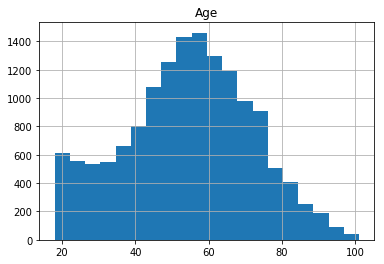

In [10]:
profile['age'].hist(bins=20)
plt.title('Age')

Text(0.5,1,'Gender')

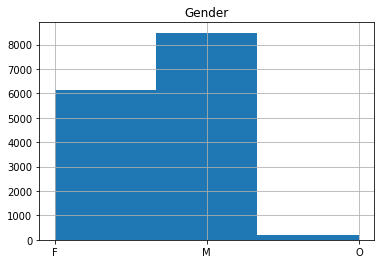

In [11]:
profile['gender'].hist(bins=3)
plt.title('Gender')

Text(0.5,1,'Income')

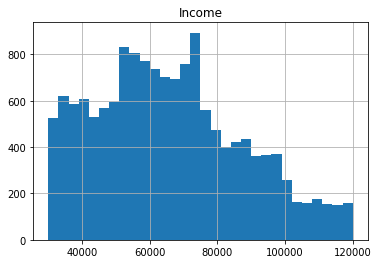

In [12]:
profile['income'].hist(bins=30)
plt.title('Income')

Text(0.5,1,'Days Become Member')

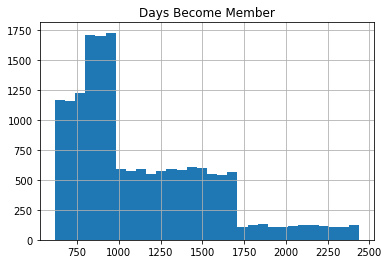

In [13]:
profile['member_days'].hist(bins=30)
plt.title('Days Become Member')

In [14]:
# clean the transcript dataframe

In [15]:
transcript.head(10)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


In [16]:
#transcript['value'].apply(pd.Series)

In [17]:
#convert the trascript['value']
transcript_values=pd.DataFrame(transcript['value'].values.tolist(), index=transcript.index)
transcript_values.head(10)

,amount,offer id,offer_id,reward
0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN
5,NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN
6,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,NaN
7,NaN,3f207df678b143eea3cee63160fa8bed,NaN,NaN
8,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
9,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN


In [18]:
transcript.drop('value',axis=1,inplace=True)

In [19]:
#cleaned transcript table
new_transcript= pd.concat([transcript, transcript_values], axis=1)
new_transcript.sort_values(by=['person']).head(10)

,event,person,time,amount,offer id,offer_id,reward
302205,transaction,0009655768c64bdeb2e877511632db8f,696,18.41,NaN,NaN,NaN
168412,transaction,0009655768c64bdeb2e877511632db8f,414,8.57,NaN,NaN,NaN
300930,transaction,0009655768c64bdeb2e877511632db8f,690,28.16,NaN,NaN,NaN
55972,offer received,0009655768c64bdeb2e877511632db8f,168,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN
153401,offer received,0009655768c64bdeb2e877511632db8f,408,NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN
233413,offer viewed,0009655768c64bdeb2e877511632db8f,540,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
228422,transaction,0009655768c64bdeb2e877511632db8f,528,14.11,NaN,NaN,NaN
228423,offer completed,0009655768c64bdeb2e877511632db8f,528,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4,2.0
77705,offer viewed,0009655768c64bdeb2e877511632db8f,192,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN
293497,transaction,0009655768c64bdeb2e877511632db8f,660,12.36,NaN,NaN,NaN


In [20]:
new_transcript=new_transcript.fillna('')
new_transcript['event_with_id']=new_transcript['event'].astype(str)+new_transcript['offer id'].astype(str)+new_transcript['offer_id'].astype(str)
new_transcript.drop(['offer id','event','offer_id','time','reward'],axis=1,inplace=True)
new_transcript.sort_values(by=['person']).head(10)


,person,amount,event_with_id
302205,0009655768c64bdeb2e877511632db8f,18.41,transaction
168412,0009655768c64bdeb2e877511632db8f,8.57,transaction
300930,0009655768c64bdeb2e877511632db8f,28.16,transaction
55972,0009655768c64bdeb2e877511632db8f,,offer received5a8bc65990b245e5a138643cd4eb9837
153401,0009655768c64bdeb2e877511632db8f,,offer receivedf19421c1d4aa40978ebb69ca19b0e20d
233413,0009655768c64bdeb2e877511632db8f,,offer viewedfafdcd668e3743c1bb461111dcafc2a4
228422,0009655768c64bdeb2e877511632db8f,14.11,transaction
228423,0009655768c64bdeb2e877511632db8f,,offer completedfafdcd668e3743c1bb461111dcafc2a4
77705,0009655768c64bdeb2e877511632db8f,,offer viewed5a8bc65990b245e5a138643cd4eb9837
293497,0009655768c64bdeb2e877511632db8f,12.36,transaction


In [21]:
#only get the transaction row
transaction=new_transcript.loc[new_transcript['event_with_id']=='transaction']
transaction.head(10)

,person,amount,event_with_id
12654,02c083884c7d45b39cc68e1314fec56c,0.83,transaction
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,34.56,transaction
12659,54890f68699049c2a04d415abc25e717,13.23,transaction
12670,b2f1cd155b864803ad8334cdf13c4bd2,19.51,transaction
12671,fe97aa22dd3e48c8b143116a8403dd52,18.97,transaction
12678,629fc02d56414d91bca360decdfa9288,33.9,transaction
12686,bbeb54e861614fc7b22a8844f72dca6c,0.22,transaction
12687,a97e6f33219c432db82acfa0d19c602d,18.59,transaction
12691,676506bad68e4161b9bbaffeb039626b,18.01,transaction
12696,8f7dd3b2afe14c078eb4f6e6fe4ba97d,19.11,transaction


In [22]:
# person_amount_spend
person_amount_spend=transaction.groupby('person')['amount'].sum()
person_amount_spend=person_amount_spend.to_frame()
person_amount_spend=person_amount_spend.reset_index()
person_amount_spend.head(10)

,person,amount
0,0009655768c64bdeb2e877511632db8f,127.60
1,00116118485d4dfda04fdbaba9a87b5c,4.09
2,0011e0d4e6b944f998e987f904e8c1e5,79.46
3,0020c2b971eb4e9188eac86d93036a77,196.86
4,0020ccbbb6d84e358d3414a3ff76cffd,154.05
5,003d66b6608740288d6cc97a6903f4f0,48.34
6,00426fe3ffde4c6b9cb9ad6d077a13ea,68.51
7,004b041fbfe44859945daa2c7f79ee64,138.36
8,004c5799adbf42868b9cff0396190900,347.38
9,005500a7188546ff8a767329a2f7c76a,20.36


In [23]:
# all about the offer,received, completed, viewed.

about_offer=new_transcript.loc[new_transcript['event_with_id']!='transaction'].drop(['amount'],axis=1)
about_offer["value"]=1
about_offer.sort_values(by=['person']).head(10)

,person,event_with_id,value
187554,0009655768c64bdeb2e877511632db8f,offer viewedf19421c1d4aa40978ebb69ca19b0e20d,1
228423,0009655768c64bdeb2e877511632db8f,offer completedfafdcd668e3743c1bb461111dcafc2a4,1
168413,0009655768c64bdeb2e877511632db8f,offer completedf19421c1d4aa40978ebb69ca19b0e20d,1
77705,0009655768c64bdeb2e877511632db8f,offer viewed5a8bc65990b245e5a138643cd4eb9837,1
233413,0009655768c64bdeb2e877511632db8f,offer viewedfafdcd668e3743c1bb461111dcafc2a4,1
55972,0009655768c64bdeb2e877511632db8f,offer received5a8bc65990b245e5a138643cd4eb9837,1
258884,0009655768c64bdeb2e877511632db8f,offer completed2906b810c7d4411798c6938adc9daaa5,1
247879,0009655768c64bdeb2e877511632db8f,offer received2906b810c7d4411798c6938adc9daaa5,1
153401,0009655768c64bdeb2e877511632db8f,offer receivedf19421c1d4aa40978ebb69ca19b0e20d,1
139992,0009655768c64bdeb2e877511632db8f,offer viewed3f207df678b143eea3cee63160fa8bed,1


In [24]:
#use pivot function to format all offers to new columns.
offer_table=pd.pivot_table(about_offer, values="value", index=["person"], columns="event_with_id", aggfunc="count" , fill_value=0) 
offer_table.head(10)

event_with_id,offer completed0b1e1539f2cc45b7b9fa7c272da2e1d7,offer completed2298d6c36e964ae4a3e7e9706d1fb8c2,offer completed2906b810c7d4411798c6938adc9daaa5,offer completed4d5c57ea9a6940dd891ad53e9dbe8da0,offer completed9b98b8c7a33c4b65b9aebfe6a799e6d9,offer completedae264e3637204a6fb9bb56bc8210ddfd,offer completedf19421c1d4aa40978ebb69ca19b0e20d,offer completedfafdcd668e3743c1bb461111dcafc2a4,offer received0b1e1539f2cc45b7b9fa7c272da2e1d7,offer received2298d6c36e964ae4a3e7e9706d1fb8c2,...,offer viewed0b1e1539f2cc45b7b9fa7c272da2e1d7,offer viewed2298d6c36e964ae4a3e7e9706d1fb8c2,offer viewed2906b810c7d4411798c6938adc9daaa5,offer viewed3f207df678b143eea3cee63160fa8bed,offer viewed4d5c57ea9a6940dd891ad53e9dbe8da0,offer viewed5a8bc65990b245e5a138643cd4eb9837,offer viewed9b98b8c7a33c4b65b9aebfe6a799e6d9,offer viewedae264e3637204a6fb9bb56bc8210ddfd,offer viewedf19421c1d4aa40978ebb69ca19b0e20d,offer viewedfafdcd668e3743c1bb461111dcafc2a4
person,,,,,,,,,,,,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,0,0,1,0,0,0,1,1,0,0,...,0,0,0,1,0,1,0,0,1,1
00116118485d4dfda04fdbaba9a87b5c,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0
0011e0d4e6b944f998e987f904e8c1e5,1,1,0,0,1,0,0,0,1,1,...,1,1,0,1,0,1,1,0,0,0
0020c2b971eb4e9188eac86d93036a77,0,0,0,1,0,0,0,2,0,0,...,0,0,0,0,1,1,0,0,0,1
0020ccbbb6d84e358d3414a3ff76cffd,0,1,0,0,1,0,1,0,0,1,...,0,1,0,0,0,1,1,0,1,0
003d66b6608740288d6cc97a6903f4f0,1,0,0,0,0,0,0,2,1,0,...,0,0,0,1,0,1,0,0,0,2
00426fe3ffde4c6b9cb9ad6d077a13ea,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,1,0,0,0,1
004b041fbfe44859945daa2c7f79ee64,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,1,1
004c5799adbf42868b9cff0396190900,0,0,0,0,0,1,2,2,0,0,...,0,0,0,0,0,0,0,0,2,2


In [25]:
offer_table.iloc[1].sum()

4

In [26]:
results=pd.merge(profile,person_amount_spend, on='person', how='outer').drop(['became_member_on','today'],axis=1)
results.head(10)

,age,gender,person,income,member_days,amount
0,NaN,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,1145.0,20.40
1,55.0,F,0610b486422d4921ae7d2bf64640c50b,112000.0,992.0,77.01
2,NaN,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,630.0,14.30
3,75.0,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1059.0,159.27
4,NaN,None,a03223e636434f42ac4c3df47e8bac43,NaN,972.0,4.65
5,68.0,M,e2127556f4f64592b11af22de27a7932,70000.0,707.0,57.73
6,NaN,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN,920.0,NaN
7,NaN,None,68617ca6246f4fbc85e91a2a49552598,NaN,913.0,0.24
8,65.0,M,389bc3fa690240e798340f5a15918d5c,53000.0,783.0,36.43
9,NaN,None,8974fc5686fe429db53ddde067b88302,NaN,1227.0,15.62


In [27]:
results=pd.merge(results,offer_table, on='person', how='outer')
results.head(10)

,age,gender,person,income,member_days,amount,offer completed0b1e1539f2cc45b7b9fa7c272da2e1d7,offer completed2298d6c36e964ae4a3e7e9706d1fb8c2,offer completed2906b810c7d4411798c6938adc9daaa5,offer completed4d5c57ea9a6940dd891ad53e9dbe8da0,...,offer viewed0b1e1539f2cc45b7b9fa7c272da2e1d7,offer viewed2298d6c36e964ae4a3e7e9706d1fb8c2,offer viewed2906b810c7d4411798c6938adc9daaa5,offer viewed3f207df678b143eea3cee63160fa8bed,offer viewed4d5c57ea9a6940dd891ad53e9dbe8da0,offer viewed5a8bc65990b245e5a138643cd4eb9837,offer viewed9b98b8c7a33c4b65b9aebfe6a799e6d9,offer viewedae264e3637204a6fb9bb56bc8210ddfd,offer viewedf19421c1d4aa40978ebb69ca19b0e20d,offer viewedfafdcd668e3743c1bb461111dcafc2a4
0,NaN,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,1145.0,20.40,0.0,1.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
1,55.0,F,0610b486422d4921ae7d2bf64640c50b,112000.0,992.0,77.01,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NaN,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,630.0,14.30,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,75.0,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1059.0,159.27,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0
4,NaN,None,a03223e636434f42ac4c3df47e8bac43,NaN,972.0,4.65,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,68.0,M,e2127556f4f64592b11af22de27a7932,70000.0,707.0,57.73,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
6,NaN,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN,920.0,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0
7,NaN,None,68617ca6246f4fbc85e91a2a49552598,NaN,913.0,0.24,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
8,65.0,M,389bc3fa690240e798340f5a15918d5c,53000.0,783.0,36.43,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,1.0
9,NaN,None,8974fc5686fe429db53ddde067b88302,NaN,1227.0,15.62,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0


In [28]:
results.dtypes

age                                                float64
gender                                              object
person                                              object
income                                             float64
member_days                                        float64
amount                                             float64
offer completed0b1e1539f2cc45b7b9fa7c272da2e1d7    float64
offer completed2298d6c36e964ae4a3e7e9706d1fb8c2    float64
offer completed2906b810c7d4411798c6938adc9daaa5    float64
offer completed4d5c57ea9a6940dd891ad53e9dbe8da0    float64
offer completed9b98b8c7a33c4b65b9aebfe6a799e6d9    float64
offer completedae264e3637204a6fb9bb56bc8210ddfd    float64
offer completedf19421c1d4aa40978ebb69ca19b0e20d    float64
offer completedfafdcd668e3743c1bb461111dcafc2a4    float64
offer received0b1e1539f2cc45b7b9fa7c272da2e1d7     float64
offer received2298d6c36e964ae4a3e7e9706d1fb8c2     float64
offer received2906b810c7d4411798c6938adc9daaa5     float

#Final table

In [29]:
results.sort_values(by=['age']).head(10)

,age,gender,person,income,member_days,amount,offer completed0b1e1539f2cc45b7b9fa7c272da2e1d7,offer completed2298d6c36e964ae4a3e7e9706d1fb8c2,offer completed2906b810c7d4411798c6938adc9daaa5,offer completed4d5c57ea9a6940dd891ad53e9dbe8da0,...,offer viewed0b1e1539f2cc45b7b9fa7c272da2e1d7,offer viewed2298d6c36e964ae4a3e7e9706d1fb8c2,offer viewed2906b810c7d4411798c6938adc9daaa5,offer viewed3f207df678b143eea3cee63160fa8bed,offer viewed4d5c57ea9a6940dd891ad53e9dbe8da0,offer viewed5a8bc65990b245e5a138643cd4eb9837,offer viewed9b98b8c7a33c4b65b9aebfe6a799e6d9,offer viewedae264e3637204a6fb9bb56bc8210ddfd,offer viewedf19421c1d4aa40978ebb69ca19b0e20d,offer viewedfafdcd668e3743c1bb461111dcafc2a4
4016,18.0,M,68012cc999eb42fda88b5f9b54603d9c,67000.0,905.0,86.56,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
6763,18.0,F,4e3afc3a5bd54635b938093420edf973,46000.0,681.0,17.15,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
5906,18.0,M,2ba1d65405594702af723081531011ef,38000.0,1646.0,209.08,2.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2270,18.0,M,f0039c5cc78442b1af05a8bfa7548084,53000.0,1296.0,77.63,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
750,18.0,M,d62cf96d9f19459e8ddb11720f1fa78c,36000.0,1249.0,104.76,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
6743,18.0,M,2f31ca6bc8f741f2b1a809a38971d6bb,40000.0,617.0,52.64,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
14253,18.0,M,717eee391dc44e9aba4315b917ebaa35,45000.0,617.0,15.63,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0
5456,18.0,M,abdc98fc32234a17b962e035422289fd,47000.0,1190.0,109.29,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
10628,18.0,M,613264e64735440194fdb2bfbea37bf6,53000.0,849.0,156.21,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0
7808,18.0,M,b901d4c1272944f198e4a708b89e6591,52000.0,659.0,17.04,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0


In [30]:
#map the person id to the numbers

def person_mapper():
    coded_dict = dict()
    cter = 0
    person_encoded = []
    
    for val in results['person']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        person_encoded.append(coded_dict[val])
    return person_encoded

person_encoded = person_mapper()
del results['person']
results['person_id'] = person_encoded



In [31]:
df=results


In [32]:
dummy_cols_df = pd.get_dummies(results.drop(['person_id'],axis=1))
dummy_cols_df.head(10)

,age,income,member_days,amount,offer completed0b1e1539f2cc45b7b9fa7c272da2e1d7,offer completed2298d6c36e964ae4a3e7e9706d1fb8c2,offer completed2906b810c7d4411798c6938adc9daaa5,offer completed4d5c57ea9a6940dd891ad53e9dbe8da0,offer completed9b98b8c7a33c4b65b9aebfe6a799e6d9,offer completedae264e3637204a6fb9bb56bc8210ddfd,...,offer viewed3f207df678b143eea3cee63160fa8bed,offer viewed4d5c57ea9a6940dd891ad53e9dbe8da0,offer viewed5a8bc65990b245e5a138643cd4eb9837,offer viewed9b98b8c7a33c4b65b9aebfe6a799e6d9,offer viewedae264e3637204a6fb9bb56bc8210ddfd,offer viewedf19421c1d4aa40978ebb69ca19b0e20d,offer viewedfafdcd668e3743c1bb461111dcafc2a4,gender_F,gender_M,gender_O
0,NaN,NaN,1145.0,20.40,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0,0,0
1,55.0,112000.0,992.0,77.01,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
2,NaN,NaN,630.0,14.30,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0,0,0
3,75.0,100000.0,1059.0,159.27,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1,0,0
4,NaN,NaN,972.0,4.65,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
5,68.0,70000.0,707.0,57.73,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0,1,0
6,NaN,NaN,920.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,2.0,0,0,0
7,NaN,NaN,913.0,0.24,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0,0,0
8,65.0,53000.0,783.0,36.43,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,2.0,0.0,2.0,1.0,0,1,0
9,NaN,NaN,1227.0,15.62,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0,0,0


In [33]:
dummy_cols_df_dropna=dummy_cols_df.dropna()

In [34]:
dummy_cols_df_dropna

,age,income,member_days,amount,offer completed0b1e1539f2cc45b7b9fa7c272da2e1d7,offer completed2298d6c36e964ae4a3e7e9706d1fb8c2,offer completed2906b810c7d4411798c6938adc9daaa5,offer completed4d5c57ea9a6940dd891ad53e9dbe8da0,offer completed9b98b8c7a33c4b65b9aebfe6a799e6d9,offer completedae264e3637204a6fb9bb56bc8210ddfd,...,offer viewed3f207df678b143eea3cee63160fa8bed,offer viewed4d5c57ea9a6940dd891ad53e9dbe8da0,offer viewed5a8bc65990b245e5a138643cd4eb9837,offer viewed9b98b8c7a33c4b65b9aebfe6a799e6d9,offer viewedae264e3637204a6fb9bb56bc8210ddfd,offer viewedf19421c1d4aa40978ebb69ca19b0e20d,offer viewedfafdcd668e3743c1bb461111dcafc2a4,gender_F,gender_M,gender_O
1,55.0,112000.0,992.0,77.01,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
3,75.0,100000.0,1059.0,159.27,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1,0,0
5,68.0,70000.0,707.0,57.73,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0,1,0
8,65.0,53000.0,783.0,36.43,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,2.0,0.0,2.0,1.0,0,1,0
12,58.0,51000.0,873.0,15.62,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1,0
13,61.0,57000.0,934.0,85.55,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1,0,0
14,26.0,46000.0,2240.0,56.22,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,1,0
15,62.0,71000.0,1512.0,160.25,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1,0,0
16,49.0,52000.0,1967.0,144.11,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0,1,0
18,57.0,42000.0,823.0,19.10,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0


In [35]:
dummy_cols_df_dropna.shape

(14487, 35)

In [62]:
dummy_cols_df_dropna.sum()

age                                                7.866660e+05
income                                             9.448420e+08
member_days                                        1.659112e+07
amount                                             1.734692e+06
offer completed0b1e1539f2cc45b7b9fa7c272da2e1d7    3.386000e+03
offer completed2298d6c36e964ae4a3e7e9706d1fb8c2    4.886000e+03
offer completed2906b810c7d4411798c6938adc9daaa5    3.911000e+03
offer completed4d5c57ea9a6940dd891ad53e9dbe8da0    3.310000e+03
offer completed9b98b8c7a33c4b65b9aebfe6a799e6d9    4.188000e+03
offer completedae264e3637204a6fb9bb56bc8210ddfd    3.657000e+03
offer completedf19421c1d4aa40978ebb69ca19b0e20d    4.103000e+03
offer completedfafdcd668e3743c1bb461111dcafc2a4    5.003000e+03
offer received0b1e1539f2cc45b7b9fa7c272da2e1d7     6.553000e+03
offer received2298d6c36e964ae4a3e7e9706d1fb8c2     6.525000e+03
offer received2906b810c7d4411798c6938adc9daaa5     6.456000e+03
offer received3f207df678b143eea3cee63160

Offer complete rate

In [79]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [75]:
dummy_cols_df_dropna['offer completedae264e3637204a6fb9bb56bc8210ddfd'].sum()/dummy_cols_df_dropna['offer receivedae264e3637204a6fb9bb56bc8210ddfd'].sum()

0.55943093162000923

In [76]:
(dummy_cols_df_dropna['offer completed4d5c57ea9a6940dd891ad53e9dbe8da0'].sum())/(dummy_cols_df_dropna['offer received4d5c57ea9a6940dd891ad53e9dbe8da0'].sum())

0.51175015460729745

In [77]:
dummy_cols_df_dropna['offer completed9b98b8c7a33c4b65b9aebfe6a799e6d9'].sum()/dummy_cols_df_dropna['offer received9b98b8c7a33c4b65b9aebfe6a799e6d9'].sum()

0.64017120146744111

In [78]:
dummy_cols_df_dropna['offer completed0b1e1539f2cc45b7b9fa7c272da2e1d7'].sum()/dummy_cols_df_dropna['offer received0b1e1539f2cc45b7b9fa7c272da2e1d7'].sum()

0.51670990386082705

In [80]:
dummy_cols_df_dropna['offer completed2298d6c36e964ae4a3e7e9706d1fb8c2'].sum()/dummy_cols_df_dropna['offer received2298d6c36e964ae4a3e7e9706d1fb8c2'].sum()

0.74881226053639849

In [81]:
dummy_cols_df_dropna['offer completedfafdcd668e3743c1bb461111dcafc2a4'].sum()/dummy_cols_df_dropna['offer receivedfafdcd668e3743c1bb461111dcafc2a4'].sum()

0.76969230769230768

In [82]:
dummy_cols_df_dropna['offer completedf19421c1d4aa40978ebb69ca19b0e20d'].sum()/dummy_cols_df_dropna['offer receivedf19421c1d4aa40978ebb69ca19b0e20d'].sum()

0.63879806943795736

In [83]:
dummy_cols_df_dropna['offer completed2906b810c7d4411798c6938adc9daaa5'].sum()/dummy_cols_df_dropna['offer received2906b810c7d4411798c6938adc9daaa5'].sum()

0.60579306071871131

# ML

In [37]:
#statistical details of the dataset

dummy_cols_df_dropna.describe()

,age,income,member_days,amount,offer completed0b1e1539f2cc45b7b9fa7c272da2e1d7,offer completed2298d6c36e964ae4a3e7e9706d1fb8c2,offer completed2906b810c7d4411798c6938adc9daaa5,offer completed4d5c57ea9a6940dd891ad53e9dbe8da0,offer completed9b98b8c7a33c4b65b9aebfe6a799e6d9,offer completedae264e3637204a6fb9bb56bc8210ddfd,...,offer viewed3f207df678b143eea3cee63160fa8bed,offer viewed4d5c57ea9a6940dd891ad53e9dbe8da0,offer viewed5a8bc65990b245e5a138643cd4eb9837,offer viewed9b98b8c7a33c4b65b9aebfe6a799e6d9,offer viewedae264e3637204a6fb9bb56bc8210ddfd,offer viewedf19421c1d4aa40978ebb69ca19b0e20d,offer viewedfafdcd668e3743c1bb461111dcafc2a4,gender_F,gender_M,gender_O
count,14487.000000,14487.000000,14487.000000,14487.000000,14487.000000,14487.000000,14487.000000,14487.000000,14487.000000,14487.000000,...,14487.000000,14487.000000,14487.000000,14487.000000,14487.000000,14487.000000,14487.000000,14487.000000,14487.000000,14487.000000
mean,54.301512,65219.990336,1145.242148,119.741295,0.233727,0.337268,0.269966,0.228481,0.289087,0.252433,...,0.233658,0.428384,0.398081,0.234762,0.400221,0.425692,0.432526,0.413405,0.572513,0.014082
std,17.434279,21599.018396,420.223727,130.234349,0.493825,0.576838,0.526474,0.492504,0.538155,0.516593,...,0.491546,0.627582,0.610850,0.488623,0.612782,0.631437,0.630345,0.492461,0.494731,0.117831
min,18.000000,30000.000000,616.000000,0.150000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,42.000000,49000.000000,828.000000,34.210000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,55.000000,63000.000000,979.000000,89.960000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,66.000000,79000.000000,1421.000000,162.780000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,101.000000,120000.000000,2439.000000,1608.690000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,...,4.000000,4.000000,5.000000,4.000000,4.000000,5.000000,4.000000,1.000000,1.000000,1.000000


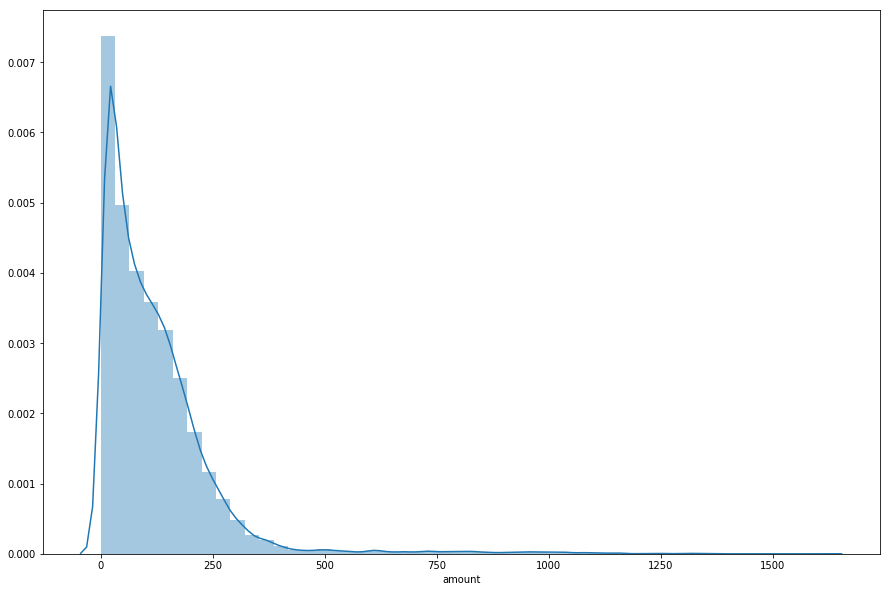

In [38]:
#check the average value of the “amount” column

plt.figure(figsize=(15,10))
plt.tight_layout()
sns.distplot(dummy_cols_df_dropna['amount'])

In [39]:
X = dummy_cols_df_dropna.drop(['amount'],axis=1)
y=dummy_cols_df_dropna['amount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 

lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit
        
#Predict and score the model
y_test_preds = lm_model.predict(X_test) 
"The r-squared score for the model using only quantitative variables was {} on {} values.".format(r2_score(y_test, y_test_preds), len(y_test))

'The r-squared score for the model using only quantitative variables was 0.3506163217486742 on 4347 values.'

In [40]:
y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train)

#Score using your model
test_score = r2_score(y_test, y_test_preds)
train_score = r2_score(y_train, y_train_preds)
test_RMSE = np.sqrt(mean_squared_error(y_test,y_test_preds))
train_RMSE = np.sqrt(mean_squared_error(y_train, y_train_preds))

In [41]:
print("The rsquared on the training data was {}.  The rsquared on the test data was {}.".format(train_score, test_score))
print("The RMSE on the training data was {}.  The RMSE on the test data was {}.".format(train_RMSE, test_RMSE))

The rsquared on the training data was 0.33740160391773255.  The rsquared on the test data was 0.3506163217486742.
The RMSE on the training data was 107.0154681841654.  The RMSE on the test data was 102.56260212485687.


In [42]:
#compare the actural customer spend with predicted.

plot_for_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_preds}).head(25)
plot_for_results

,Actual,Predicted
10223,265.98,191.968750
13951,65.45,164.996094
2785,229.64,229.859375
7354,20.73,39.410156
205,62.65,94.812500
2387,147.02,195.500000
11816,67.01,14.714844
2289,203.93,225.593750
16810,349.20,226.757812
14926,14.92,-41.074219


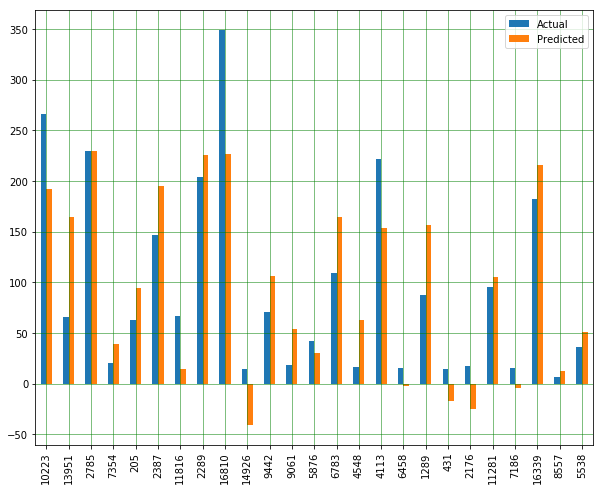

In [43]:
plot_for_results.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [44]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
coef_df.head(20)

,est_int,coefs,abs_coefs
31,gender_F,3.256956e+13,3.256956e+13
33,gender_O,3.256956e+13,3.256956e+13
32,gender_M,3.256956e+13,3.256956e+13
8,offer completedae264e3637204a6fb9bb56bc8210ddfd,5.611445e+01,5.611445e+01
6,offer completed4d5c57ea9a6940dd891ad53e9dbe8da0,4.843824e+01,4.843824e+01
10,offer completedfafdcd668e3743c1bb461111dcafc2a4,4.743561e+01,4.743561e+01
9,offer completedf19421c1d4aa40978ebb69ca19b0e20d,4.726107e+01,4.726107e+01
4,offer completed2298d6c36e964ae4a3e7e9706d1fb8c2,4.016098e+01,4.016098e+01
5,offer completed2906b810c7d4411798c6938adc9daaa5,3.940648e+01,3.940648e+01
3,offer completed0b1e1539f2cc45b7b9fa7c272da2e1d7,3.898061e+01,3.898061e+01


In [45]:
corr =dummy_cols_df_dropna.corr()
corr

,age,income,member_days,amount,offer completed0b1e1539f2cc45b7b9fa7c272da2e1d7,offer completed2298d6c36e964ae4a3e7e9706d1fb8c2,offer completed2906b810c7d4411798c6938adc9daaa5,offer completed4d5c57ea9a6940dd891ad53e9dbe8da0,offer completed9b98b8c7a33c4b65b9aebfe6a799e6d9,offer completedae264e3637204a6fb9bb56bc8210ddfd,...,offer viewed3f207df678b143eea3cee63160fa8bed,offer viewed4d5c57ea9a6940dd891ad53e9dbe8da0,offer viewed5a8bc65990b245e5a138643cd4eb9837,offer viewed9b98b8c7a33c4b65b9aebfe6a799e6d9,offer viewedae264e3637204a6fb9bb56bc8210ddfd,offer viewedf19421c1d4aa40978ebb69ca19b0e20d,offer viewedfafdcd668e3743c1bb461111dcafc2a4,gender_F,gender_M,gender_O
age,1.000000,0.306425,0.015757,0.112488,0.064242,0.018278,0.052562,0.070331,0.031971,0.064280,...,0.044589,-0.003566,-0.018602,0.034534,-0.029537,0.002230,0.003598,0.152544,-0.151832,-0.000051
income,0.306425,1.000000,0.031944,0.329549,0.145869,0.046160,0.106320,0.157783,0.075809,0.157433,...,0.065914,0.005550,-0.045832,0.047493,-0.044946,0.006804,0.000429,0.230158,-0.226067,-0.012745
member_days,0.015757,0.031944,1.000000,0.154508,0.067766,0.090773,0.082159,0.055894,0.072139,0.047355,...,0.029283,-0.000015,-0.007433,0.035190,-0.001351,-0.006893,0.002545,-0.018661,0.020974,-0.010071
amount,0.112488,0.329549,0.154508,1.000000,0.207541,0.155477,0.174357,0.233278,0.149011,0.247632,...,0.054053,0.023347,-0.012555,0.075674,0.032361,0.031820,0.077094,0.157553,-0.158898,0.008679
offer completed0b1e1539f2cc45b7b9fa7c272da2e1d7,0.064242,0.145869,0.067766,0.207541,1.000000,0.009454,0.037145,0.049775,0.019002,0.047967,...,0.005925,-0.055354,-0.058791,0.008896,-0.052046,-0.048349,-0.048242,0.086070,-0.090004,0.018175
offer completed2298d6c36e964ae4a3e7e9706d1fb8c2,0.018278,0.046160,0.090773,0.155477,0.009454,1.000000,-0.006150,0.001614,-0.017229,-0.011210,...,-0.032783,-0.065423,-0.075235,-0.034056,-0.066494,-0.052296,-0.068218,0.045225,-0.044581,-0.001831
offer completed2906b810c7d4411798c6938adc9daaa5,0.052562,0.106320,0.082159,0.174357,0.037145,-0.006150,1.000000,0.028597,0.013494,0.017954,...,-0.005825,-0.053781,-0.055144,-0.000847,-0.062324,-0.053758,-0.046306,0.062350,-0.063370,0.005483
offer completed4d5c57ea9a6940dd891ad53e9dbe8da0,0.070331,0.157783,0.055894,0.233278,0.049775,0.001614,0.028597,1.000000,0.021650,0.062255,...,0.004731,0.669591,-0.056596,-0.004034,-0.051404,-0.059721,-0.057072,0.107482,-0.106533,-0.001915
offer completed9b98b8c7a33c4b65b9aebfe6a799e6d9,0.031971,0.075809,0.072139,0.149011,0.019002,-0.017229,0.013494,0.021650,1.000000,0.012617,...,-0.015021,-0.061334,-0.044553,0.674639,-0.059895,-0.059482,-0.062763,0.069720,-0.073296,0.016358
offer completedae264e3637204a6fb9bb56bc8210ddfd,0.064280,0.157433,0.047355,0.247632,0.047967,-0.011210,0.017954,0.062255,0.012617,1.000000,...,-0.001492,-0.048250,-0.060768,-0.011630,0.649718,-0.047776,-0.055701,0.093664,-0.095261,0.008510


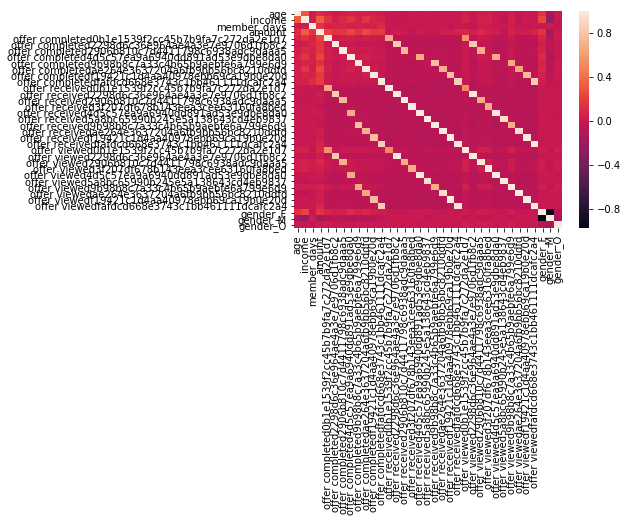

In [46]:
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)

Recommend offer to customer

In [47]:
user_item=results.drop(['age','gender','income','member_days','amount',
       'offer received0b1e1539f2cc45b7b9fa7c272da2e1d7',
       'offer received2298d6c36e964ae4a3e7e9706d1fb8c2',
       'offer received2906b810c7d4411798c6938adc9daaa5',
       'offer received3f207df678b143eea3cee63160fa8bed',
       'offer received4d5c57ea9a6940dd891ad53e9dbe8da0',
       'offer received5a8bc65990b245e5a138643cd4eb9837',
       'offer received9b98b8c7a33c4b65b9aebfe6a799e6d9',
       'offer receivedae264e3637204a6fb9bb56bc8210ddfd',
       'offer receivedf19421c1d4aa40978ebb69ca19b0e20d',
       'offer receivedfafdcd668e3743c1bb461111dcafc2a4',
       'offer viewed0b1e1539f2cc45b7b9fa7c272da2e1d7',
       'offer viewed2298d6c36e964ae4a3e7e9706d1fb8c2',
       'offer viewed2906b810c7d4411798c6938adc9daaa5',
       'offer viewed3f207df678b143eea3cee63160fa8bed',
       'offer viewed4d5c57ea9a6940dd891ad53e9dbe8da0',
       'offer viewed5a8bc65990b245e5a138643cd4eb9837',
       'offer viewed9b98b8c7a33c4b65b9aebfe6a799e6d9',
       'offer viewedae264e3637204a6fb9bb56bc8210ddfd',
       'offer viewedf19421c1d4aa40978ebb69ca19b0e20d',
       'offer viewedfafdcd668e3743c1bb461111dcafc2a4'],axis=1)
user_item=user_item.set_index('person_id')

In [48]:
user_item

,offer completed0b1e1539f2cc45b7b9fa7c272da2e1d7,offer completed2298d6c36e964ae4a3e7e9706d1fb8c2,offer completed2906b810c7d4411798c6938adc9daaa5,offer completed4d5c57ea9a6940dd891ad53e9dbe8da0,offer completed9b98b8c7a33c4b65b9aebfe6a799e6d9,offer completedae264e3637204a6fb9bb56bc8210ddfd,offer completedf19421c1d4aa40978ebb69ca19b0e20d,offer completedfafdcd668e3743c1bb461111dcafc2a4
person_id,,,,,,,,
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,1.0,0.0,1.0,0.0,2.0,1.0


In [49]:
# Most completed offer list

user_item.sum().sort_values(ascending=False)

offer completedfafdcd668e3743c1bb461111dcafc2a4    5317.0
offer completed2298d6c36e964ae4a3e7e9706d1fb8c2    5156.0
offer completed9b98b8c7a33c4b65b9aebfe6a799e6d9    4354.0
offer completedf19421c1d4aa40978ebb69ca19b0e20d    4296.0
offer completed2906b810c7d4411798c6938adc9daaa5    4017.0
offer completedae264e3637204a6fb9bb56bc8210ddfd    3688.0
offer completed0b1e1539f2cc45b7b9fa7c272da2e1d7    3420.0
offer completed4d5c57ea9a6940dd891ad53e9dbe8da0    3331.0
dtype: float64

In [50]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    user_similar=user_item.loc[user_id, :].dot(user_item.T)

    # sort by similarity
    user_similar = user_similar.sort_values(ascending=False)

    # create list of just the ids
    most_similar_users = user_similar.loc[~(user_similar.index==user_id)].index.values.tolist()
   
    # remove the own user's id
    
    
    return most_similar_users # return a list of the users in order from most to least similar

In [51]:
find_similar_users(79)

[5941,
 2955,
 7156,
 8775,
 12845,
 3552,
 4386,
 16230,
 1498,
 15172,
 11762,
 3275,
 6248,
 4828,
 300,
 11241,
 12018,
 6751,
 402,
 10268,
 14678,
 3199,
 12362,
 14633,
 15936,
 15931,
 1868,
 6637,
 3164,
 7338,
 15552,
 10072,
 10308,
 16710,
 9189,
 5631,
 6236,
 16350,
 15607,
 2100,
 10858,
 10979,
 15909,
 5749,
 9871,
 16346,
 16700,
 7907,
 13764,
 12064,
 9204,
 8571,
 12806,
 16699,
 191,
 5808,
 12437,
 2859,
 16277,
 496,
 14370,
 11594,
 10273,
 2596,
 6710,
 15467,
 11581,
 4373,
 684,
 13709,
 16013,
 2827,
 6132,
 15174,
 12402,
 1804,
 3690,
 2566,
 13526,
 185,
 5341,
 6665,
 962,
 5316,
 3388,
 15519,
 14697,
 12102,
 11007,
 7270,
 6168,
 12857,
 8634,
 10863,
 12040,
 1539,
 13394,
 13872,
 6354,
 8788,
 15076,
 16456,
 11853,
 8781,
 3547,
 8779,
 12665,
 10897,
 7588,
 8938,
 1500,
 6490,
 15698,
 13395,
 8899,
 11871,
 11887,
 11187,
 11899,
 8840,
 10404,
 6374,
 9974,
 4819,
 15767,
 2445,
 16477,
 6406,
 3986,
 4539,
 3992,
 3492,
 2189,
 1310,
 12531,

In [52]:
def find_key(dict,value):
    return (k for k, v in dict.items() if v>value)

def get_offer_name(user_id,top_m):
    offer=[]
    cleaned_offer=[]
    similar_users=find_similar_users(user_id)[:top_m]
    similar_users.append(user_id)
    for i in similar_users:
        offer.extend(list(find_key(dict(user_item.iloc[i]),0)))
    offer=list(set(offer))
    for j in offer:
        cleaned_offer.append(j[15:])
    return cleaned_offer

In [53]:
#input user_id and numbers of similar users you need. 
#output is offer you can send to this user.
#for example, we give user_id=80, and similar user=2, will return below. 

get_offer_name(80,2)

['2298d6c36e964ae4a3e7e9706d1fb8c2',
 'fafdcd668e3743c1bb461111dcafc2a4',
 'f19421c1d4aa40978ebb69ca19b0e20d',
 '9b98b8c7a33c4b65b9aebfe6a799e6d9']